In [1]:
from typing import Any
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from tqdm import tqdm
import xgboost
import catboost
import uproot
import coffea
import hist
import vector
import copy
vector.register_awkward()

/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#help(train_test_split)

In [3]:
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

In [4]:
era = "2018"
tttt_evts = []
ttjj_evts = []
ttbb_evts = []
tttt = None
ttjj = None
ttbb = None
for channel in ["ElMu", "MuMu", "ElEl"]:
    handle = NanoEventsFactory.from_root(
        f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/{era}___tttt.root",
        schemaclass=BaseSchema, 
        entry_stop=None
    ).events()
    if tttt is None:
        tttt = handle
    else:
        tttt = ak.concatenate([tttt, handle])
    print("tttt", len(tttt))
        
    for proc in ["ttother_DL-GF_fr", "ttother_DL_fr", "ttother_DL_nr", 
                 "ttother_SL-GF_fr", "ttother_SL_fr", "ttother_SL_nr",]:
        handle = NanoEventsFactory.from_root(
            f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/{era}___{proc}.root",
            schemaclass=BaseSchema, 
            entry_stop=None
        ).events()
        if ttjj is None:
            ttjj = handle
        else:
            ttjj = ak.concatenate([ttjj, handle])
        print("ttjj", len(ttjj))
        
    for proc in ["ttbb_DL-GF_fr", "ttbb_DL_fr", "ttbb_DL_nr", 
                 "ttbb_SL-GF_fr", "ttbb_SL_fr", "ttbb_SL_nr",]:
        handle = NanoEventsFactory.from_root(
            f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/{era}___{proc}.root",
            schemaclass=BaseSchema, 
            entry_stop=None
        ).events()
        if ttbb is None:
            ttbb = handle
        else:
            ttbb = ak.concatenate([ttbb, handle])
        print("ttbb", len(ttbb))

tttt 208181
ttjj 744126
ttjj 832048
ttjj 911001
ttjj 914168
ttjj 914633
ttjj 917256
ttbb 24965
ttbb 27982
ttbb 29063
ttbb 29292
ttbb 29317
ttbb 29384
tttt 316793
ttjj 1319065
ttjj 1366562
ttjj 1409692
ttjj 1410785
ttjj 1410941
ttjj 1411885
ttbb 42808
ttbb 44362
ttbb 45004
ttbb 45121
ttbb 45136
ttbb 45176
tttt 408411
ttjj 1738999
ttjj 1777566
ttjj 1811626
ttjj 1813153
ttjj 1813349
ttjj 1814481
ttbb 55872
ttbb 57120
ttbb 57579
ttbb 57670
ttbb 57687
ttbb 57714


In [5]:
events = tttt

In [6]:
print(len(tttt), len(ttjj), len(ttbb))

408411 1814481 57714


In [7]:
bTagWorkingPointDict = dict()
bTagWorkingPointDict[False] = {
        "2016": {
            "DeepCSV": {"L": 0.2217, "M": 0.6321, "T": 0.8953, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0614, "M": 0.3093, "T": 0.7221, "Var": "btagDeepFlavB"},
        },
        "2017": {
            "CSVv2": {"L": 0.5803, "M": 0.8838, "T": 0.9693, "Var": "btagCSVV2"},
            "DeepCSV": {"L": 0.1522, "M": 0.4941, "T": 0.8001, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0521, "M": 0.3033, "T": 0.7489, "Var": "btagDeepFlavB"},
        },
        "2018": {
            "DeepCSV": {"L": 0.1241, "M": 0.4184, "T": 0.7527, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0494, "M": 0.2770, "T": 0.7264, "Var": "btagDeepFlavB"},
        },  # Non-UL WPs
    }
bTagWorkingPointDict[True] = {
        "2016preVFP": {
            "DeepCSV": {"L": 0.2027, "M": 0.6001, "T": 0.8819, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0508, "M": 0.2598, "T": 0.6502, "Var": "btagDeepFlavB"},
        },
        "2016postVFP": {
            "DeepCSV": {"L": 0.1918, "M": 0.5847, "T": 0.8767, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0480, "M": 0.2489, "T": 0.6377, "Var": "btagDeepFlavB"},
        },
        "2017": {
            "DeepCSV": {"L": 0.1355, "M": 0.4506, "T": 0.7738, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0532, "M": 0.3040, "T": 0.7476, "Var": "btagDeepFlavB"},
        },
        "2018": {
            "DeepCSV": {"L": 0.1208, "M": 0.4168, "T": 0.7665, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0490, "M": 0.2783, "T": 0.7100, "Var": "btagDeepFlavB"},
        },  # UL WPs
    }
scale_systematic = "nom"
#the_var = bTagWorkingPointDict[False][era]["DeepJet"]["Var"]
the_var = f"FTAJet__{scale_systematic}_DeepJetB"
the_wp = bTagWorkingPointDict[False][era]["DeepJet"]["M"]

In [8]:
len(tttt), len(ttjj), len(ttbb)

(408411, 1814481, 57714)

In [9]:
model_vLF = None
model_vHF = None
model_nested_layer1 = None
model_nested_layer2 = None

In [10]:
def get_features(events, 
                 is_mc=True,
                 remove_negative_weights=False, 
                 normalize_weights=False,
                 scale_systematic="nom", 
                 wgt_systematic="nom", 
                 e_filter=lambda e: e.dsid1k < 500,
                 named_models_features=None
                ):
    ret = dict()
    mus = ak.zip({"pt": events.FTAMuon_pt, 
                  "eta": events.FTAMuon_eta, 
                  "phi": events.FTAMuon_phi, 
                  "mass": events.FTAMuon_mass,
                  "loose": events.FTAMuon_looseId,
                  #"isolation": (events.FTAMuon_pfIsoId >= 4)
                 },
                 with_name="Momentum4D"
                )
    els = ak.zip({"pt": events.FTAElectron_pt, 
                  "eta": events.FTAElectron_eta, 
                  "phi": events.FTAElectron_phi, 
                  "mass": events.FTAElectron_mass,
                  "loose": (events.FTAElectron_cutBased >= 2),
                  #"isolation": (don't have it... le sigh)
                 },
                 with_name="Momentum4D"
                )
    jets = ak.zip({"pt": getattr(events, f"FTAJet__{scale_systematic}_pt"), 
                  "eta": getattr(events, f"FTAJet__{scale_systematic}_eta"), 
                  "phi": getattr(events, f"FTAJet__{scale_systematic}_phi"), 
                  "mass": getattr(events, f"FTAJet__{scale_systematic}_mass"),
                  "btag": getattr(events, f"FTAJet__{scale_systematic}_DeepJetB"),
                 },
                 with_name="Momentum4D"
                )

    selection = (
        (ak.num(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1) >= 4) 
        & (ak.sum(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1) >= 500)
        & (np.abs(getattr(events, f"FTAMuon_InvariantMass") - 91) > 15)
        & (
            (getattr(events, f"FTAMuon_InvariantMass") < 0)
            | (getattr(events, f"FTAMuon_InvariantMass") > 20)
        )
        & (
            (ak.num(els, axis=1) + ak.num(mus, axis=1)) == 2
        )
        & (getattr(events, f"nMediumDeepJetB__{scale_systematic}") > 1)
    )
    if is_mc:
        if remove_negative_weights:
            selection = selection & (getattr(events, f"wgt___{wgt_systematic}") > 0)
    if e_filter:
        selection = selection & (e_filter(events))
        
    events = events[selection]
    mus = mus[selection]
    els = els[selection]
    jets = jets[selection]
    bsrt = ak.argsort(jets.btag, axis=1, ascending=False)
    at_least_three_jets = ak.num(jets, axis=1) > 2
    fallback = -0.1 * ak.ones_like(at_least_three_jets)
    
    ret["MET_pt"] = ak.to_numpy(getattr(events, f"FTAMET__{scale_systematic}_pt"))
    ret["MET_phi"] = ak.to_numpy(getattr(events, f"FTAMET__{scale_systematic}_phi"))
    ret["Lepton1_pt"] = ak.to_numpy(events.FTALepton1_pt)
    ret["Lepton2_pt"] = ak.to_numpy(events.FTALepton2_pt)
    ret["Lepton1_eta"] = ak.to_numpy(events.FTALepton1_eta)
    ret["Lepton2_eta"] = ak.to_numpy(events.FTALepton2_eta)
    ret["nMediumDeepJetB"] = ak.to_numpy(getattr(events, f"nMediumDeepJetB__{scale_systematic}"))
    ret["nJet"] = np.asarray(ak.num(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1))
    # Add in the 4+ jet pts, the lepton isolations, the 4+ jet btag discriminants
    ret["ST"] = ak.to_numpy(getattr(events, f"ST__{scale_systematic}"))
    ret["HT"] = ak.to_numpy(getattr(events, f"HT__{scale_systematic}"))
    # ret["HT2M"] = getattr(events, f"HT2M__{scale_systematic}") # Errors
    ret["HT2M"] = ak.to_numpy(ak.where(
        at_least_three_jets, ak.sum(jets[bsrt][:, 2:].pt, axis=1), fallback
    ))
    # ret["H2M"] = getattr(events, f"H2M__{scale_systematic}") # Errors
    ret["H2M"] = ak.to_numpy(ak.where(
        at_least_three_jets, ak.sum(jets[bsrt][:, 2:].p, axis=1), fallback
    ))
    # ret["HTRat"] = getattr(events, f"HTRat__{scale_systematic}") # Errors
    ret["HTRat"] = (ak.to_numpy(
        ak.where(
            at_least_three_jets, ak.sum(jets[bsrt][:, 0:2].pt, axis=1), fallback
        )
        / ret["HT"]
    ))
    ret["H"] = ak.to_numpy(getattr(events, f"H__{scale_systematic}"))
    # ret["HTH"] = getattr(events, f"HTH__{scale_systematic}")
    ret["HTH"] = ret["HT"] / ret["H"]
    ret["HTb"] = ak.to_numpy(getattr(events, f"HTb__{scale_systematic}"))
    ret["dRll"] = ak.to_numpy(events.FTALepton_dRll)
    ret["dRbb"] = ak.to_numpy(getattr(events, f"dRbb__{scale_systematic}"))
    ret["bdisc_1"] = ak.to_numpy(jets[bsrt][:, 0].btag)
    ret["bdisc_2"] = ak.to_numpy(jets[bsrt][:, 1].btag)
    ret["bdisc_3"] = ak.to_numpy(jets[bsrt][:, 2].btag)
    ret["bdisc_4"] = ak.to_numpy(jets[bsrt][:, 3].btag)
    ret["jetpt_1"] = ak.to_numpy(jets[:, 0].pt)
    ret["jetpt_2"] = ak.to_numpy(jets[:, 1].pt)
    ret["jetpt_3"] = ak.to_numpy(jets[:, 2].pt)
    ret["jetpt_4"] = ak.to_numpy(jets[:, 3].pt)
    if is_mc:
        ret["wgt"] = ak.to_numpy(getattr(events, f"wgt___{wgt_systematic}"))
        ret["wgt_normed"] = ret["wgt"]/np.sum(ret["wgt"])
    else:
        ret["wgt"] = None
        ret["wgt_normed"] = None
    
    if named_models_features is not None:
        for name, model, features in named_models_features:
            if len(events) == 0:
                ret[name] = np.array([], dtype=np.float32)
                continue
            inputs = np.column_stack([ret[feat] for feat in features])
            ret[name] = model.predict_proba(inputs)[:, 0]
            #ret[f"model_{index}"] = copy.deepcopy(model.predict_proba(inputs)[:, 1])

    return ret

In [11]:
UNNESTED = ['MET_pt', 'MET_phi', 'Lepton1_pt', 'Lepton2_pt', 'nJet', 'HT', 'HT2M', 'HTRat', 
            'H', 'H2M', 'HTH', 'HTb', 'dRll', 'dRbb', 'bdisc_1', 'bdisc_2', 'bdisc_3', 'bdisc_4',
            'jetpt_1', 'jetpt_2', 'jetpt_3', 'jetpt_4']
TRAIN_vLF = UNNESTED
TRAIN_vHF = UNNESTED
REMOVED = ['Lepton1_eta', 'Lepton2_eta', 'nMediumDeepJetB']
#ADD BACK IN jet pt's, maybe the eta's???
#LAYER1 = ["nJet", "HT", "HTH", "HTRat", "HTb", "bdisc_1", "bdisc_2", "bdisc_3", "bdisc_4", "MET_pt", "Lepton2_pt", 
#          "dRll", "dRbb", "jetpt_1", "jetpt_2", "jetpt_3", "jetpt_4"]
TRAIN_LAYER1 = UNNESTED
#LAYER2 = LAYER1 + ["nested_layer1"]
#TRAIN_nested_layer1 = LAYER1
#TRAIN_nested_layer2 = LAYER2
opt_models = {
    "vLF":
    {"catboost": None,
     "xgboost": None},
    "vHF":
    {"catboost": None,
     "xgboost": None},
    "nested_layer1":
    {"catboost": None,
     "xgboost": None},
    "nested_layer2":
    {"catboost": None,
     "xgboost": None},
}
model_inputs = {
    "vLF":
    {"catboost": TRAIN_vLF,
     "xgboost": TRAIN_vLF},
    "vHF":
    {"catboost": TRAIN_vHF,
     "xgboost": TRAIN_vHF},
    "nested_layer1":
    {"catboost": TRAIN_LAYER1,
     "xgboost": TRAIN_LAYER1},
    "nested_layer2":
    {"catboost": TRAIN_LAYER1 + ["catboost_nested_layer1"],
     "xgboost": TRAIN_LAYER1 + ["xgboost_nested_layer1"]},
}

In [41]:
params = {
    "vLF": {
        "xgboost": {
            "ntrees": 100,
            "lrate": 0.015625},
        "catboost": {
            "ntrees": 500,
            "lrate": 0.984375}
    },
    "vHF": {
        "xgboost": {
            "ntrees": 500,
            "lrate": 0.1},
        "catboost": {
            "ntrees": 500,
            "lrate": 0.1}
    },
    "nested_layer1": {
        "xgboost": {
            "ntrees": 500,
            "lrate": 0.1},
        "catboost": {
            "ntrees": 500,
            "lrate": 0.1}
    },
    "nested_layer2": {
        "xgboost": {
            "ntrees": 500,
            "lrate": 0.1},
        "catboost": {
            "ntrees": 500,
            "lrate": 0.1}
    }
}

In [13]:
mode = "vLF"
#mode = "vHF"
#mode = "nested_layer1"
#mode = "nested_layer2"

In [14]:
if mode in ["vLF", "vHF"]:
    TRAIN_FEATURES = UNNESTED
elif mode == "nested_layer1":
    TRAIN_FEATURES = LAYER1
elif mode == "nested_layer2":
    #train against ttbb, with 
    raise ValueError("We need to rework this to do both models in parallel")
    TRAIN_FEATURES = LAYER2 + ["model_0"]
for feat in TRAIN_FEATURES:
    print(feat)
    
#Load up our dataframes for training... could cut out the pandas, but whatevs
dfs = []
if mode in ["vLF", "nested_layer1"]:
    print("tttt vs ttlight")
    dfs.append(pd.DataFrame(get_features(tttt, is_mc=True, remove_negative_weights=True, 
                                         normalize_weights=True, scale_systematic="nom", wgt_systematic="nom")
                     ).assign(proc=lambda x: 0))
    dfs.append(pd.DataFrame(get_features(ttjj, is_mc=True, remove_negative_weights=True, 
                                         normalize_weights=True, scale_systematic="nom", wgt_systematic="nom")
                      ).assign(proc=lambda x: 1))
if mode in ["vHF", "nested_layer2"]:
    print("tttt vs ttbb")
    if mode == "vHF":
        named_models_features = None
    elif mode == "nested_layer2":
        if model_nested_layer1 is None:
            raise ValueError("Untrained model, need to load it from somewhere!")
        named_models_features = [("nested_layer1", model_nested_layer1, LAYER1)]
    dfs.append(pd.DataFrame(get_features(tttt, is_mc=True, remove_negative_weights=True, 
                                         normalize_weights=True, scale_systematic="nom", wgt_systematic="nom",
                                         named_models_features = named_models_features)
                     ).assign(proc=lambda x: 0))
    dfs.append(pd.DataFrame(get_features(ttbb, is_mc=True, remove_negative_weights=True,
                                         normalize_weights=True,
                                         scale_systematic="nom", wgt_systematic="nom",
                                         named_models_features = named_models_features
                                        )
                      ).assign(proc=lambda x: 1))
data = pd.concat(dfs, axis=0)
prcs = data['proc']
print("signal:", len(prcs[prcs == 0]), "background:",len(prcs[prcs == 1]))

MET_pt
MET_phi
Lepton1_pt
Lepton2_pt
nJet
HT
HT2M
HTRat
H
H2M
HTH
HTb
dRll
dRbb
bdisc_1
bdisc_2
bdisc_3
bdisc_4
jetpt_1
jetpt_2
jetpt_3
jetpt_4
tttt vs ttlight
signal: 114251 background: 457958


In [35]:
print(TRAIN_FEATURES)

if True:
    #Normalize xgboost weights
    sig_mask = (data.proc == 0)
    bkg_mask = (data.proc == 1)
    data.loc[sig_mask, "wgt"] = np.sum(sig_mask) / np.sum(data.wgt[sig_mask]) * data.loc[sig_mask, "wgt"]
    data.loc[bkg_mask, "wgt"] = np.sum(sig_mask) / np.sum(data.wgt[bkg_mask]) * data.loc[bkg_mask, "wgt"]
    
X_train, X_valtest, y_train, y_valtest, w_train_cb, w_valtest_cb, w_train_xgb, w_valtest_xgb,  = train_test_split(
    data.loc[:, TRAIN_FEATURES].values,
    data.proc,
    data.wgt_normed,
    data.wgt,
    #data.loc[:, ["wgt", "wgt_normed"]], #Use unnormalized weight for XGBoost, normalized for CatBoost!
    test_size=0.2,
    random_state=12421)

X_test, X_val, y_test, y_val, w_test_cb, w_val_cb, w_test_xgb, w_val_xgb,  = train_test_split(
    X_valtest,
    y_valtest,
    w_valtest_cb,
    w_valtest_xgb,
    test_size=0.8,

    random_state=5451)

['MET_pt', 'MET_phi', 'Lepton1_pt', 'Lepton2_pt', 'nJet', 'HT', 'HT2M', 'HTRat', 'H', 'H2M', 'HTH', 'HTb', 'dRll', 'dRbb', 'bdisc_1', 'bdisc_2', 'bdisc_3', 'bdisc_4', 'jetpt_1', 'jetpt_2', 'jetpt_3', 'jetpt_4']
114251 457958
114251.00000000003 114251.0
114251.0 114251.0


In [16]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(np.int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()
    
def plot_feature_importances_2d(f_imps1, f_names1, f_imps2, f_names2, f_label1, f_label2, title=""):
    if f_names1 != f_names2:
        raise NotImplementedError("Must have same feature order")
    
    annotations = f_names1
    
    f_imps1 = np.array(f_imps1)
    f_names1 = np.array(f_names1)
    f_imps2 = np.array(f_imps2)
    f_names2 = np.array(f_names2)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.scatter(f_imps1, f_imps2)
    for i, label in enumerate(annotations):
        plt.annotate(label, (f_imps1[i]+0.02, f_imps2[i]+0.02))
    plt.xlabel(f_label1, size=14)
    plt.ylabel(f_label2, size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title(title, size=14)
    plt.show()
    
def plot_xgboost_validation(model):
    results = model.evals_result()
    eval_metrics = list(results["validation_0"].keys())#[0]
    n_metrics = len(eval_metrics)
    fig, axs = plt.subplots(ncols=1, nrows=n_metrics, figsize=(10, n_metrics * 10),)
                        #constrained_layout=True)
    for emi, eval_metric in enumerate(eval_metrics):
        axs[emi].plot(results["validation_0"][eval_metric], label="Training "+eval_metric)
        axs[emi].plot(results["validation_1"][eval_metric], label="Validation "+eval_metric)
        #plt.axvline(21, color="gray", label="Optimal tree number")
        axs[emi].set(xlabel="Number of trees", ylabel=eval_metric)
        #axs[emi].xlabel("Number of trees")
        #axs[emi].ylabel(eval_metric)
        axs[emi].legend()


In [17]:
import time
def evaluate_models(models_dict):
    for model_name, model in models_dict.items():
        start = time.time()
        w_test=None
        max_trees = 10 #int(params[mode][model_name]["ntrees"]/10)
        l_rate = params[mode][model_name]["lrate"]
        if isinstance(model, xgboost.sklearn.XGBClassifier):
            w_test = w_test_xgb
            model.learning_rate = l_rate
            print(f"{model_name} learning rate: {model.learning_rate}")
            # Modified: evaluation, early_stopping usese the 'last' eval_metric and last eval_set
            eval_set = [(X_train, y_train), (X_val, y_val)]
            w_set = [w_train_xgb, w_val_xgb]
            #eval_set = [(X_val, y_val)]
            #w_set = [w_val[:,0]]
            model.fit(X_train, y_train,
                      sample_weight=w_train_xgb,
                      verbose=True,
                      #eval_metric="auc", # We use that metric for final scoring
                      eval_metric=["error", "logloss", "auc"],
                      early_stopping_rounds=max_trees, # Try training this more rounds after reaching the best score
                      #eval_set=eval_set,
                      #sample_weight_eval_set=[w_val]
                      eval_set=eval_set,
                      sample_weight_eval_set=w_set,
                      ) # Note that we use separate datasets for test and early stopping
        elif isinstance(model, catboost.core.CatBoostClassifier):
            #CATBOOST eval_metric is set in the constructor!
            w_test = w_test_cb
            max_trees = int(params[mode][model_name]["ntrees"]/10)
            model.set_params(learning_rate=l_rate)
            print(f"{model_name} learning rate: {l_rate}")
            # Modified: evaluation
            val_cb = catboost.Pool(data=X_val, label=y_val, weight=w_val_cb)
            model.fit(X_train, y_train,
                      sample_weight=w_train_cb, #NEW
                      verbose=True,
                      early_stopping_rounds=max_trees,
                      eval_set=val_cb,
                      plot=True,
                     )                           
                
        # model.fit(X_train, y_train, sample_weight=w_train)
        end = time.time()
        print("{}; train time {:.3f} s; ROC AUC = {:.3f}".format(
              model_name,
              end - start,
              roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], sample_weight=w_test)))

In [18]:
def find_optimal_learning_rate(model, model_name, verbose:bool=False, return_best_model:bool=False, tolerance:float=0.01):
    """
    Uses early stopping and bisection method to efficiently find the optimal learning rate.
    
    Boosting model performance is almost always a convex function of the learning rate when all other parameters are held constant.
    When the learning rate is too low, the model underfits and underperformes; when it's too high, the model overfits.
    The optimal learning rate is some sweet spot between 0 and 1. We can use this knowelage to create a smart
    algorithm for finding the optimal learning rate.
    We don't need to train a boosting model fully to know whether it overfits or underfits, as we can use early stopping!
    If early stopping kicked in, that means the learning rate is too high. If it doesn't, this means it's too low.
    
    The funciton finds the highest learning rate for which early stopping doesn't kick in.
    Arg:
        model: a model with sklearn-type interface.
           Supports XGBClassifier, LGBMClassifier, CatBoostClassifier
        verbose: print the progress
        return_best_model: if set, return (learning_rate, best_model)
           if not set, return just learning_rate
        tolerance: the maximum difference betweent the truly optimal and retured value
    Returns:
        optimal learning rate, if return_best_model is false
        (optimal learning rate, best model) if return_best_model true
    """
    # Use eval_set, w_val and val_cb for measuring the performance
    # YOUR CODE HERE
    max_trees = 10 #int(params[mode][model_name]["ntrees"]/10) #30
    
    learning_rate = 0.5
    lr_low = 0.0
    lr_high = 1.0
    stop = False
    itrn = 0
    start_time = time.time()
    cmodel = clone(model)
    while(~stop):
        total_time = time.time() - start_time
        print(f"iteration {itrn} learning_rate {learning_rate} at {total_time}s")
        itrn += 1
        #if isinstance(cmodel, lightgbm.sklearn.LGBMClassifier):
        #    cmodel.learning_rate = learning_rate
        #    cmodel.fit(X_train, y_train,
        #      verbose=False,
        #      eval_metric="auc",
        #      early_stopping_rounds=max_trees,
        #      eval_set=eval_set,
        #      eval_sample_weight=[w_val])
        #elif isinstance(cmodel, xgboost.sklearn.XGBClassifier):
        if isinstance(cmodel, xgboost.sklearn.XGBClassifier):
            cmodel.learning_rate = learning_rate
            eval_set = [(X_train, y_train), (X_val, y_val)]
            w_set = [w_train_xgb, w_val_xgb]
            cmodel.fit(X_train, y_train,
              sample_weight=w_train_xgb,
              verbose=False,
              #eval_metric="auc", # We use that metric for final scoring
              eval_metric=["error", "logloss", "auc"],
              early_stopping_rounds=max_trees, # Try training this more rounds after reaching the best score
              eval_set=eval_set,
              sample_weight_eval_set=w_set
             ) # Note that we use separate datasets for test and early stopping
        elif isinstance(cmodel, catboost.core.CatBoostClassifier):
            cmodel.set_params(learning_rate=learning_rate)
            # not the way we pass the validaton weights to catboost
            val_cb = catboost.Pool(data=X_val, label=y_val, weight=w_val_cb)
            cmodel.fit(X_train, y_train,
                       sample_weight=w_train_cb,
                       verbose=False,
                       early_stopping_rounds=max_trees,
                       eval_set=val_cb
                      )
        n_trees = None
        if isinstance(cmodel, xgboost.sklearn.XGBClassifier):
            n_trees = len(cmodel.get_booster().get_dump())
        #elif isinstance(cmodel, lightgbm.sklearn.LGBMClassifier):
        #    n_trees = cmodel.booster_.num_trees()
        elif isinstance(cmodel, catboost.core.CatBoostClassifier):
            n_trees = cmodel.tree_count_
            #print(n_trees, max_trees)

        if (isinstance(cmodel, xgboost.sklearn.XGBClassifier) and n_trees > max_trees + 1) or\
           (isinstance(cmodel, catboost.core.CatBoostClassifier) and n_trees < max_trees + 1): #or\
           #(isinstance(cmodel, lightgbm.sklearn.LGBMClassifier) and n_trees < max_trees + 1):
            #early stop, lower the learning rate
            lr_high = learning_rate
            if abs(learning_rate - lr_low)/2 < tolerance:
                break
            learning_rate -= abs(learning_rate - lr_low)/2
        else:
            #no early stop, raise the rate
            lr_low = learning_rate
            if abs(lr_high - learning_rate)/2 < tolerance:
                break
            learning_rate += abs(lr_high - learning_rate)/2
        cmodel = clone(model) #new model, in the event we haven't stopped. This is principally for catboost
            
    best_model = cmodel
        
    if return_best_model:
        return (learning_rate, best_model)
    else:
        return learning_rate


In [19]:
eval_set = [(X_val, y_val)]
models_cpu = {
    "catboost": catboost.CatBoostClassifier(n_estimators=params[mode]["catboost"]["ntrees"], verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(n_estimators=params[mode]["xgboost"]["ntrees"], tree_method="hist", nthread=-1, use_label_encoder=False),
}

In [36]:
#find optimal learning rate, early-stopped model for catboost
#eval_metric="AUC"
eval_metric=None #Default
lr_cb, clf_cb = find_optimal_learning_rate(
  catboost.CatBoostClassifier(n_estimators=params[mode]["catboost"]["ntrees"], verbose=False, task_type='CPU',
                             eval_metric=eval_metric),
  "catboost",
  verbose=True, return_best_model=True)
print(lr_cb)

iteration 0 learning_rate 0.5 at 0.0001556873321533203s
iteration 1 learning_rate 0.75 at 6.524273872375488s
iteration 2 learning_rate 0.875 at 12.129086256027222s
iteration 3 learning_rate 0.9375 at 18.45795178413391s
iteration 4 learning_rate 0.96875 at 24.782296419143677s
iteration 5 learning_rate 0.984375 at 30.760749578475952s
0.984375


In [37]:
lr_xgb, clf_xgb = find_optimal_learning_rate(
    xgboost.XGBClassifier(n_estimators=params[mode]["xgboost"]["ntrees"], nthread=-1, use_label_encoder=False), 
    "xgboost",
    verbose=True, return_best_model=True)
print(lr_xgb)
#plot_feature_importances(clf_xgb.feature_importances_, TRAIN_FEATURES, 
#                         title=f"XGBoost {era} {mode}")
#plot_xgboost_validation(clf_xgb)

iteration 0 learning_rate 0.5 at 0.0012035369873046875s
iteration 1 learning_rate 0.25 at 38.194435596466064s
iteration 2 learning_rate 0.125 at 99.4063184261322s
iteration 3 learning_rate 0.0625 at 214.17624473571777s
iteration 4 learning_rate 0.03125 at 288.5866949558258s
iteration 5 learning_rate 0.015625 at 359.7734043598175s
0.015625


In [38]:
if False:
    for lr in np.logspace(-4, 1, num=5):
        for nt in np.logspace(1, 3, num=4):
            print(lr, max(1, int(nt)))
            mod = xgboost.XGBClassifier(n_estimators=max(1, int(nt)), nthread=-1, use_label_encoder=False)
            mod.learning_rate = lr
            eval_set = [(X_train, y_train), (X_val, y_val)]
            w_set = [w_train_xgb, w_val_xgb]
            mod.fit(X_train, y_train,
                    #sample_weight=w_train_xgb,
                    verbose=False,
                    #eval_metric="auc", # We use that metric for final scoring
                    eval_metric=["error", "logloss", "auc"],
                    early_stopping_rounds=5, # Try training this more rounds after reaching the best score
                    eval_set=eval_set,
                    sample_weight_eval_set=w_set
                    )
            print(len(mod.get_booster().get_dump()),
                  roc_auc_score(y_train, mod.predict_proba(X_train)[:, 1], sample_weight=w_train_xgb),
                  roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1], sample_weight=w_test_xgb),
                  "\n"
                 )

In [40]:
opt_models[mode]["catboost"] = clf_cb
opt_models[mode]["xgboost"] = clf_xgb
print("catboost train", roc_auc_score(y_train, clf_cb.predict_proba(X_train)[:, 1], sample_weight=w_train_cb))
print("catboost test", roc_auc_score(y_test, clf_cb.predict_proba(X_test)[:, 1], sample_weight=w_test_cb))
print("xgboost train", roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1], sample_weight=w_train_xgb))
print("xgboost test", roc_auc_score(y_test, clf_xgb.predict_proba(X_test)[:, 1], sample_weight=w_test_xgb))

catboost train 0.9443443581899064
catboost test 0.9410228323727101
xgboost train 0.9388085970318735
xgboost test 0.936181171431212


In [42]:
# Reset the models
#eval_set = [(X_val, y_val)]
models_cpu = {
    "catboost": catboost.CatBoostClassifier(n_estimators=params[mode]["catboost"]["ntrees"], verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(n_estimators=params[mode]["xgboost"]["ntrees"], tree_method="hist", nthread=-1, use_label_encoder=False),
}

In [43]:
evaluate_models(models_cpu)

catboost learning rate: 0.984375


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3522824	test: 0.3500494	best: 0.3500494 (0)	total: 73.7ms	remaining: 36.8s
1:	learn: 0.3359511	test: 0.3363456	best: 0.3363456 (1)	total: 114ms	remaining: 28.5s
2:	learn: 0.3265353	test: 0.3272786	best: 0.3272786 (2)	total: 149ms	remaining: 24.8s
3:	learn: 0.3209718	test: 0.3228503	best: 0.3228503 (3)	total: 186ms	remaining: 23s
4:	learn: 0.3188200	test: 0.3209748	best: 0.3209748 (4)	total: 239ms	remaining: 23.6s
5:	learn: 0.3162594	test: 0.3190833	best: 0.3190833 (5)	total: 278ms	remaining: 22.9s
6:	learn: 0.3133388	test: 0.3166529	best: 0.3166529 (6)	total: 314ms	remaining: 22.1s
7:	learn: 0.3110579	test: 0.3147035	best: 0.3147035 (7)	total: 353ms	remaining: 21.7s
8:	learn: 0.3087288	test: 0.3130087	best: 0.3130087 (8)	total: 448ms	remaining: 24.4s
9:	learn: 0.3074200	test: 0.3125596	best: 0.3125596 (9)	total: 523ms	remaining: 25.6s
10:	learn: 0.3060744	test: 0.3122804	best: 0.3122804 (10)	total: 565ms	remaining: 25.1s
11:	learn: 0.3051469	test: 0.3118548	best: 0.3118548 

/tmp/nmangane/ipykernel_2103/2660663110.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


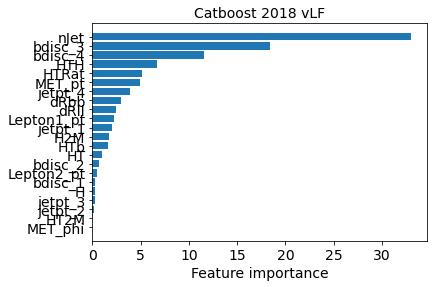

In [44]:
#plot_feature_importances(models_cpu["catboost"].get_feature_importance(), TRAIN_FEATURES, 
#                         title=f"Catboost {era} {mode}")
plot_feature_importances(opt_models[mode]["catboost"].get_feature_importance(), TRAIN_FEATURES, 
                         title=f"Catboost {era} {mode}")

/tmp/nmangane/ipykernel_2103/2660663110.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


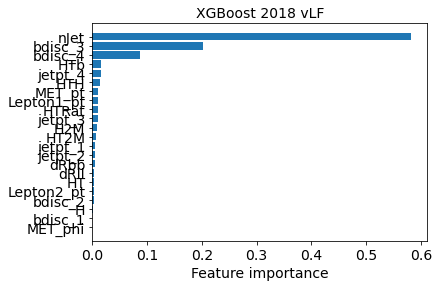

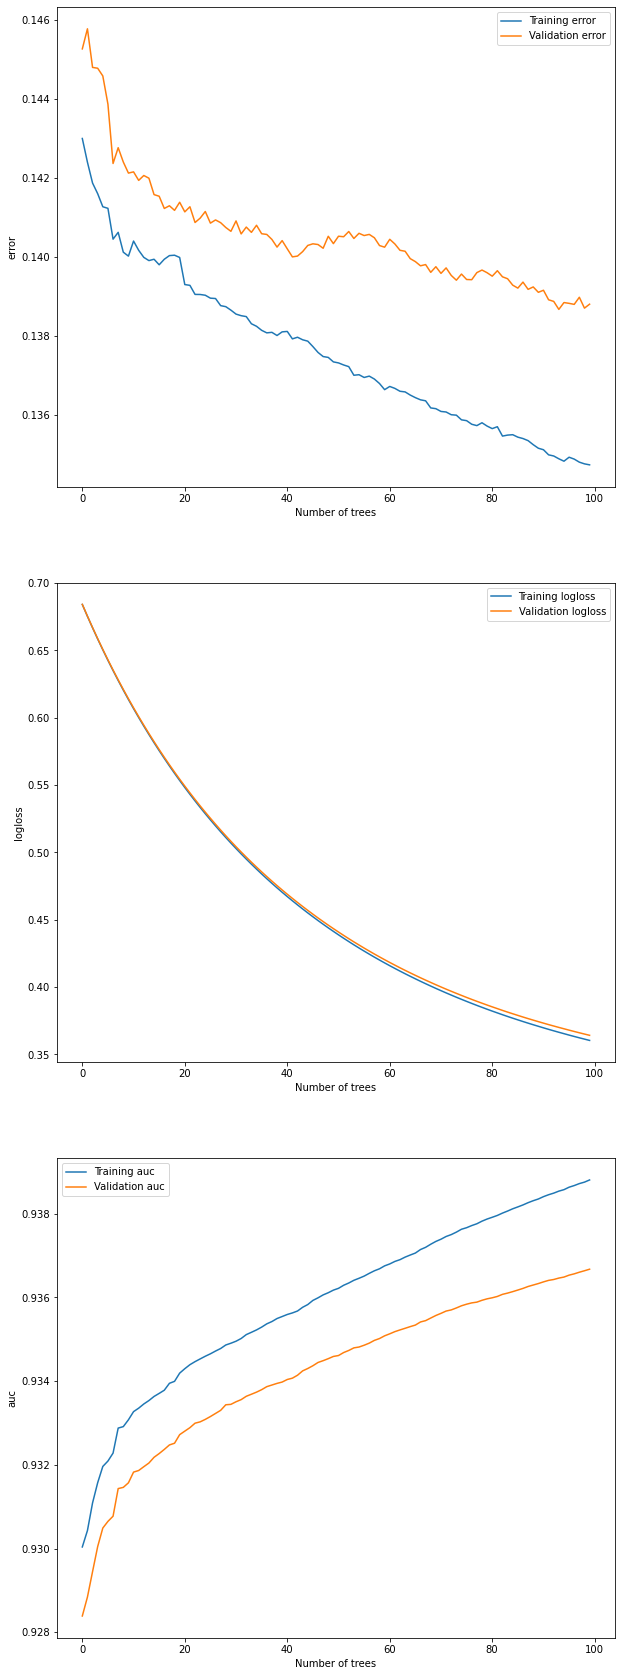

In [45]:
#plot_feature_importances(models_cpu["xgboost"].feature_importances_, TRAIN_FEATURES, 
#                         title=f"XGBoost {era} {mode}")
#plot_xgboost_validation(models_cpu["xgboost"]) #model.evals_result()
plot_feature_importances(opt_models[mode]["xgboost"].feature_importances_, TRAIN_FEATURES, 
                         title=f"XGBoost {era} {mode}")
plot_xgboost_validation(opt_models[mode]["xgboost"]) 

In [26]:
#help(models_cpu["xgboost"].evals_result)
#results

In [46]:
#preferred = "xgboost"
preferred = "catboost"
if preferred == "catboost":
    w_test = w_test_cb
elif preferred == "xgboost":
    w_test = w_test_xgb
print(mode, preferred)
if mode == "vLF":
    model_vLF = models_cpu[preferred]
    print(roc_auc_score(y_test, model_vLF.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "vHF":
    model_vHF = models_cpu[preferred]
    print(roc_auc_score(y_test, model_vHF.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "nested_layer1":
    model_nested_layer1 = models_cpu[preferred]
    print(roc_auc_score(y_test, model_nested_layer1.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "nested_layer2":
    model_nested_layer2 = models_cpu[preferred]
    print(roc_auc_score(y_test, model_nested_layer2.predict_proba(X_test)[:, 1], sample_weight=w_test))
print(model_vLF, model_vHF,  model_nested_layer1,  model_nested_layer2)

models_cpu["catboost"].save_model(f"catboost_{mode}_{era}",
                                     format="cbm",
                                     export_parameters=None,
                                     pool=None
                                    )
models_cpu["xgboost"].save_model(f"xgboost_{mode}_{era}.json")
with open(f"{mode}_{era}.inputs", "w") as fi:
    for variable in TRAIN_FEATURES:
        fi.write(variable)

vLF catboost
0.9410228323727101
<catboost.core.CatBoostClassifier object at 0x7f0fbaa322b0> None None None


In [28]:
if model_vLF and model_vHF:
    if hasattr(model_vLF, "feature_importances_"):
        fi1 = model_vLF.feature_importances_
    elif hasattr(model_vLF, "get_feature_importance"):
        fi1 = model_vLF.get_feature_importance()
        
    if hasattr(model_vHF, "feature_importances_"):
        fi2 = model_vHF.feature_importances_
    elif hasattr(model_vHF, "get_feature_importance"):
        fi2 = model_vHF.get_feature_importance()
        
    plot_feature_importances_2d(fi1, TRAIN_FEATURES, 
                                fi2, TRAIN_FEATURES,
                                "tttt vs ttlight feature importance", 
                                "tttt vs ttbb feature importance",
                                title=preferred)

In [29]:
#### TRY PROCESSING ALL THE DATASETS ####

In [47]:
class SimplePlotter(processor.ProcessorABC):
    def __init__(self, channel: str, named_models_features: Any = None, mode = None):
        self.channel = channel
        self.named_models_features = named_models_features
        self.mode = mode

    def process(self, events: Any) -> Any:
        # Multidimensional histograms are super dangerous... and super fun!!!!
        # This might be about 2GB if RAM for the full tttt analysis 50datasets * 50systematics * 10channels(lets do trilepton for funsies)
        # * 5btags * 10njets * 10leadleppt * 10subleadleppt * 10HTbins
        h = hist.Hist( 
            hist.axis.StrCategory([], name="era", growth=True),
            hist.axis.StrCategory([], name="dataset", growth=True),
            hist.axis.StrCategory([], name="systematic", growth=True),
            hist.axis.StrCategory(
                [], name="channel", label="lepton channel", growth=True
            ),
            hist.axis.StrCategory(
                [], name="mva_ver", label="MVA version", growth=True,
                #["vLF", "vHF", "nested_layer1", "nested_layer2"], name="mva_ver", label="MVA version", growth=False
            ),
            hist.axis.Regular(
                4,
                0,
                4,
                name="nbtag",
                label="$N_{btag}$",
                underflow=False,
                overflow=True,
            ),
            hist.axis.Regular(
                10, 2, 12, name="njet", label="$N_{jet}$", underflow=True, overflow=True
            ),
            hist.axis.Variable(
                [300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000],
                name="HT",
                label=r"$H_{T}$",
            ),
            hist.axis.Variable(
                [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                name="mva",
                label=r"MVA score",
            ),
            hist.storage.Weight(),
        )        
        dataset = events.metadata["dataset"]
        era = events.metadata.get("era", None)
        is_mc = events.metadata.get("is_mc", None)
        train_test = events.metadata.get("train_test", None)
        
        train_bound = 500
        train_mask = events.dsid1k < train_bound
        renorm = dict()
        #More efficient to only get_features for scale systematics, but... quick and dirty
        for syst in ["nom"]:
            this_wgt = getattr(events, f"wgt___{syst}")
            #multiplicative weight to scale it back up to 'nominal' size
            if self.mode is None:
                if train_test is not None:
                    raise ValueError("mode is set to None but sample is marked as a train_test split")
                fltr = None
                renorm[syst] = 1
            elif self.mode == "train":
                if train_test is None:
                    raise ValueError("mode is set to train but sample is not marked as a train_test split")
                fltr = lambda e: e.dsid1k < train_bound
                renorm[syst] = np.sum(this_wgt) / np.sum(this_wgt[train_mask])
            elif self.mode == "test":
                if train_test is None:
                    raise ValueError("mode is set to test but sample is not marked as a train_test split")
                fltr = lambda e: e.dsid1k >= train_bound
                renorm[syst] = np.sum(this_wgt) / np.sum(this_wgt[~train_mask])
            #non-train_renorm[syst] = np.sum(this_wgt) / np.sum(this_wgt[~train_mask])
            # = np.sum(this_wgt) / (np.sum(this_wgt) - np.sum(this_wgt[train_mask]))
            # = train_renorm[syst] / 
            else:
                raise ValueError("That just can't be!")
            
            
            #models_features = [(model_nested_layer1, LAYER1)]
            variables = get_features(events, 
                                 remove_negative_weights=False, # DO NOT DO IT
                                 normalize_weights=False, # NEGATORY
                                 scale_systematic="nom", # FIXME 
                                 wgt_systematic=syst,
                                 is_mc=is_mc,
                                 e_filter=fltr,
                                 named_models_features = self.named_models_features,
                                )
            
            if variables["wgt"] is not None:
                variables["wgt"] = renorm[syst] * variables["wgt"]
            for name, model, features in self.named_models_features:
                h.fill(era=era, 
                       dataset=dataset, 
                       systematic=syst, 
                       channel=self.channel, 
                       mva_ver=name,
                       nbtag=variables["nMediumDeepJetB"], 
                       njet=variables["nJet"], 
                       HT=variables["HT"], 
                       mva=variables[name],
                       weight=variables["wgt"]
                      )
        return {
            #"sumw": {dataset: ak.sum(events.genWeight) if is_mc else 0},
            # "event_id": {dataset: events.event}, #Need to copy the array somehow, or write it out instead?
            "hist": h,
        }

    def postprocess(self, accumulator: Any) -> Any:
        return accumulator



In [48]:
#from ColumnarFTA.processors.osdilepton import LeptonJetTest as LJT    
#2018___WJets_SL.root    
if era == "2018":
    suberas = ["A", "B", "C", "D"]
else:
    suberas = ["B", "C", "D", "E", "F"]
    
channel = "ElMu"
prefix=f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/"    
train_set = {
      "tttt_train": {
        "files": [
            prefix+f"{era}___tttt.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttjj_train": {
        "files": [
            prefix+f"{era}___ttother_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttbb_train": {
        "files": [
            prefix+f"{era}___ttbb_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
} 
test_set = {
      "tttt": {
        "files": [
            prefix+f"{era}___tttt.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttjj": {
        "files": [
            prefix+f"{era}___ttother_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttbb": {
        "files": [
            prefix+f"{era}___ttbb_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
}
fileset = {
    f"{channel}": {
        "files": [
            prefix+f"{era}___{channel}_{subera}.root" for subera in suberas
        ],
        "treename": "Events",
        "metadata": {"is_mc": False, "era": era},
    },
    "DY": {
        "files": [
            #prefix+f"{era}___DYJets_DL-HT100.root",
            prefix+f"{era}___DYJets_DL-HT200.root",
            prefix+f"{era}___DYJets_DL-HT400.root",
            prefix+f"{era}___DYJets_DL-HT600.root",
            prefix+f"{era}___DYJets_DL-HT800.root",
            prefix+f"{era}___DYJets_DL-HT1200.root",
            prefix+f"{era}___DYJets_DL-HT2500.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "WJets": {
        "files": [
            #prefix+f"{era}___WJets_SL-HT100.root",
            #prefix+f"{era}___WJets_SL-HT200.root",
            prefix+f"{era}___WJets_SL-HT400.root",
            prefix+f"{era}___WJets_SL-HT600.root",
            prefix+f"{era}___WJets_SL-HT800.root",
            prefix+f"{era}___WJets_SL-HT1200.root",
            prefix+f"{era}___WJets_SL-HT2500.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "Diboson": {
        "files": [
            prefix+f"{era}___WW.root",
            prefix+f"{era}___WZ.root",
            prefix+f"{era}___ZZ.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ttrare": {
        "files": [
            prefix+f"{era}___tttJ.root",
            prefix+f"{era}___tttW.root",
            prefix+f"{era}___ttWW.root",
            prefix+f"{era}___ttWZ.root",
            prefix+f"{era}___ttWH.root",
            prefix+f"{era}___ttZH.root",
            prefix+f"{era}___ttZZ.root",
            prefix+f"{era}___ttHH.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ttVJets": {
        "files": [
            prefix+f"{era}___ttZJets.root",
            prefix+f"{era}___ttWJets.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ttH": {
        "files": [
            prefix+f"{era}___ttH_DL-bb.root",
            prefix+f"{era}___ttH_SL-bb.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ST": {
        "files": [
            prefix+f"{era}___ST_tbarW-NoFHad.root",
            prefix+f"{era}___ST_tW-NoFHad.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
}

In [49]:

# https://github.com/scikit-hep/uproot4/issues/122
uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource
iterative_run = processor.Runner(
    # executor = processor.FuturesExecutor(compression=None),
    executor=processor.IterativeExecutor(compression=None),
    metadata_cache={},
    schema=BaseSchema,
    maxchunks=None,
)
nmf = []
for m_mode in opt_models:
    for classifier in opt_models[m_mode]:
        if opt_models[m_mode][classifier] is not None:
            nmf.append((f"{classifier}_{mode}", opt_models[m_mode][classifier], model_inputs[m_mode][classifier]))
#if model_vLF is not None:
#    nmf.append(("vLF", model_vLF, TRAIN_vLF))
#if model_vHF is not None:
#    nmf.append(("vHF", model_vHF, TRAIN_vHF))
#if model_nested_layer1 is not None:
#    nmf.append(("nested_layer1", model_nested_layer1, TRAIN_nested_layer1))
#if model_nested_layer2 is not None:
#    nmf.append(("nested_layer2", model_nested_layer2, TRAIN_nested_layer2))
out1 = iterative_run(
    fileset,
    treename="Events",
    processor_instance=SimplePlotter(channel=channel, 
                                     named_models_features=nmf,
                                     mode=None,
                                    ),
)
out2 = iterative_run(
    train_set,
    treename="Events",
    processor_instance=SimplePlotter(channel=channel, 
                                     named_models_features=nmf,
                                     mode="train"
                                    ),
)
out3 = iterative_run(
    test_set,
    treename="Events",
    processor_instance=SimplePlotter(channel=channel, 
                                     named_models_features=nmf,
                                     mode="test"
                                    ),
)
out = dict()
for k, v in out1.items():
    out[k] = v
for k, v in out2.items():
    out[k] += v
for k, v in out3.items():
    out[k] += v

Preprocessing:   0%|          | 0/32 [00:00<?, ?file/s]

Processing:   0%|          | 0/33 [00:00<?, ?chunk/s]

Preprocessing:   0%|          | 0/13 [00:00<?, ?file/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

In [50]:
sig = NanoEventsFactory.from_root(
            "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/ElMu/2018___tttt.root",
            schemaclass=BaseSchema, 
            entry_stop=None
        ).events()
sig_feat = get_features(sig, remove_negative_weights=False, normalize_weights=False, scale_systematic="nom",
                    wgt_systematic="nom", is_mc=True, e_filter=None,
                    #named_models_features=[("vLF", model_vLF, TRAIN_vLF)],
                  )
bkg = NanoEventsFactory.from_root(
            "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/ElMu/2018___ttother_DL-GF_fr.root",
            schemaclass=BaseSchema, 
            entry_stop=None
        ).events()
bkg_feat = get_features(bkg, remove_negative_weights=False, normalize_weights=False, scale_systematic="nom",
                    wgt_systematic="nom", is_mc=True, e_filter=None,
                    #named_models_features=[("vLF", model_vLF, TRAIN_vLF)],
                  )
results = {"sig":dict(), "bkg": dict()}
for name, model, features in [("catboost_vLF", models_cpu["catboost"], TRAIN_vLF),
                              ("xgboost_vLF", models_cpu["xgboost"], TRAIN_vLF)
                             ]:
    inputs = np.column_stack([sig_feat[feat] for feat in features])
    results["sig"][name] = model.predict_proba(inputs)
    inputs = np.column_stack([bkg_feat[feat] for feat in features])
    results["bkg"][name] = model.predict_proba(inputs)

In [51]:
print("catboost")
print("\tsignal", np.mean(results["sig"]['catboost_vLF'][:, 0]), np.mean(results["sig"]['catboost_vLF'][:, 1]))
print("\tbackground", np.mean(results["bkg"]['catboost_vLF'][:, 0]), np.mean(results["bkg"]['catboost_vLF'][:, 1]))
print("xgboost")
print("\tsignal", np.mean(results["sig"]['xgboost_vLF'][:, 0]), np.mean(results["sig"]['xgboost_vLF'][:, 1]))
print("\tbackground", np.mean(results["bkg"]['xgboost_vLF'][:, 0]), np.mean(results["bkg"]['xgboost_vLF'][:, 1]))

catboost
	signal 0.821423526282373 0.178576473717627
	background 0.24873444362952643 0.7512655563704735
xgboost
	signal 0.7393949 0.26060507
	background 0.3212832 0.6787168


/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection 

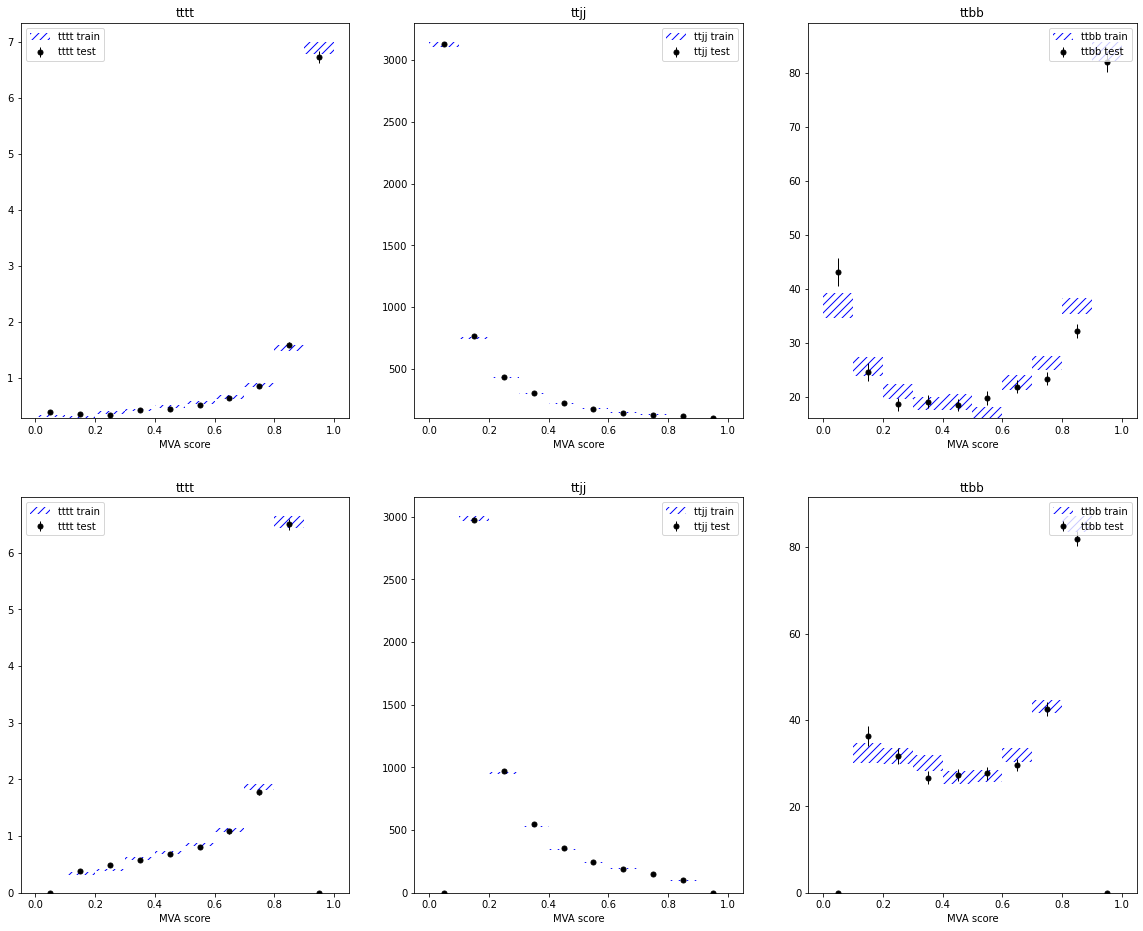

In [73]:
test = out["hist"][{"era":"2018", "systematic": "nom", "channel":"ElMu"}]
fig, axs = plt.subplots(2, 3, figsize=(20, 16))
for i, model in enumerate(["catboost", "xgboost"]):
    for j, sample in enumerate(["tttt", "ttjj", "ttbb"]):
        h_train = test[[sample+"_train"], [model+'_'+mode], ...].project("mva")
        h_test = test[[sample], [model+'_'+mode], ...].project("mva")
        #axs[j].plot(h, style='fill')
        axs[i, j].stairs(
                edges=h_train.axes[0].edges,
                baseline=h_train.values() - np.sqrt(h_train.variances()),
                values=h_train.values() + np.sqrt(h_train.variances()),
                hatch="///",
                label=sample+" train",
                facecolor="blue",
                linewidth=0,
                color="blue",
            )
        h_test.plot1d(
                    ax=axs[i, j], histtype="errorbar", color="black", label=sample+" test"
                )
        axs[i, j].set_title(sample)
        axs[i, j].legend()

      #      components = self.background.plot1d(
      #      ax=subpad,
      #      stack=True,
      #      overlay="process",
      #      histtype="fill",
      #      edgecolor=(0, 0, 0, 0.3),
      #  )
fig.savefig(f"{mode}_traintest_sigbkg.pdf", format="pdf")

/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(
/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


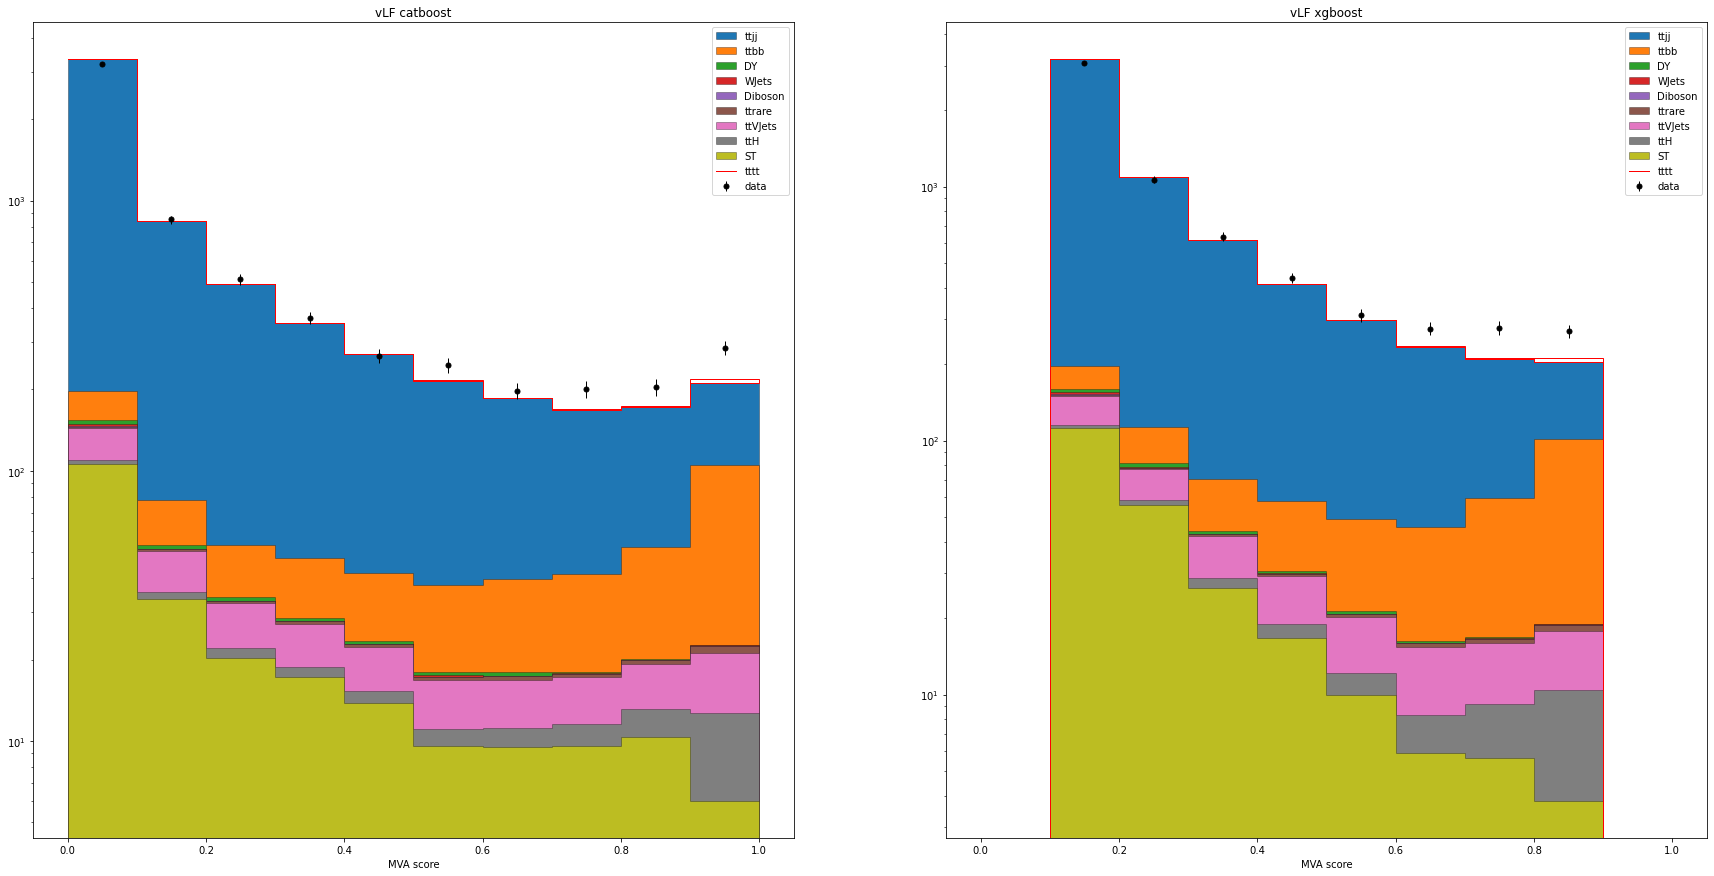

In [83]:
test = out["hist"][{"era":"2018", "systematic": "nom", "channel":"ElMu"}]
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
for i, model in enumerate(["catboost", "xgboost"]):
    bkg = test[['ST', 'ttH', 'ttVJets', 'ttrare', 'Diboson', 'WJets', 'DY', 'ttbb', 'ttjj'],
               [model+'_'+mode], ...].project("mva", "dataset")
    sig = test[['tttt'], [model+'_'+mode], ...].project("mva")
    data = test[['ElMu'], [model+'_'+mode], ...].project("mva")
    components = bkg.plot1d(
        ax=axs[i],
        stack=True,
        overlay="dataset",
        histtype="fill",
        edgecolor=(0, 0, 0, 0.3),
    )
    axs[i].stairs(
                edges=sig.axes[0].edges,
                baseline=(bkg.project("mva").values()), # - np.sqrt((bkg.project("mva")+sig).variances()),
                values=(bkg.project("mva")+sig).values(), # + np.sqrt((bkg.project("mva")+sig).variances()),
                #hatch="///",
                label="tttt",
                facecolor="red",
                linewidth=1,
                color="red",
    )
    data.plot1d(
        ax=axs[i], histtype="errorbar", color="black", label="data"
    )
    axs[i].set_title(mode+" "+model)
    axs[i].set_yscale('log')
    axs[i].legend()


fig.savefig(f"{mode}_stack.pdf", format="pdf")

In [53]:
#test[["tttt", "tttt_train", "ttjj", "ttjj_train", "ttbb", "ttbb_train"], 
#     ['vLF'], 
#     ...].project("mva", "dataset").plot(density=True)
test

Hist(
  StrCategory(['ST', 'ttH', 'ttVJets', 'ttrare', 'Diboson', 'WJets', 'DY', 'ElMu', 'ttbb_train', 'ttjj_train', 'tttt_train', 'ttbb', 'ttjj', 'tttt'], growth=True, name='dataset', label='dataset'),
  StrCategory(['catboost_vLF', 'xgboost_vLF'], growth=True, name='mva_ver', label='MVA version'),
  Regular(4, 0, 4, underflow=False, name='nbtag', label='$N_{btag}$'),
  Regular(10, 2, 12, name='njet', label='$N_{jet}$'),
  Variable([300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000], name='HT', label='$H_{T}$'),
  Variable([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], name='mva', label='MVA score'),
  storage=Weight()) # Sum: WeightedSum(value=36061.9, variance=14368.9) (WeightedSum(value=36819.9, variance=14688.4) with flow)

In [58]:
diff = test["tttt", "vHF", ...].project("mva").to_numpy()[0] - test["tttt_train", "vHF", ...].project("mva").to_numpy()[0]
print(diff)

[ 4.26054198e-05  2.79952107e-02  5.37773629e-02 -9.67943349e-03
  5.26123802e-02 -5.29842926e-02 -7.93066286e-02 -6.80532573e-02
 -2.54256195e-02 -8.07370769e-03]


In [59]:
#OLDER STUFF#

In [160]:
print("CATBOOST AUC")
print(roc_auc_score(y_test, clf_cb.predict_proba(X_test)[:, 1], sample_weight=w_test))
print("XGB AUC")
print(roc_auc_score(y_test, clf_xgb.predict_proba(X_test)[:, 1], sample_weight=w_test))

CATBOOST AUC
0.8539057567732808
XGB AUC
0.6133516187703523


/tmp/nmangane/ipykernel_25064/2498021274.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


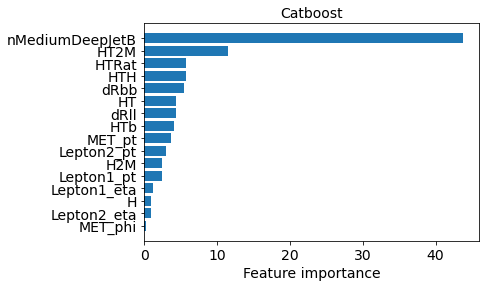

In [161]:
cb_fi = clf_cb.get_feature_importance()
plot_feature_importances(cb_fi, TRAIN_FEATURES, title="Catboost")
#for feat, imp in sorted(zip(TRAIN_FEATURES, cb_fi), key=lambda tup: tup[1], reverse=True):
#    print(f"{feat:20s} \t {imp}")

/tmp/nmangane/ipykernel_25064/2498021274.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


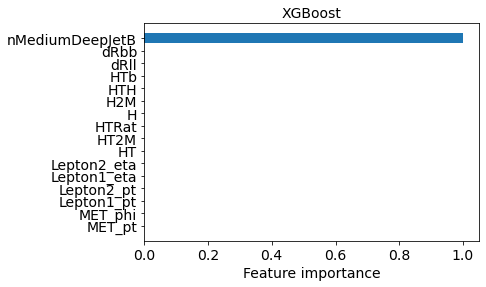

In [162]:
xgb_fi = clf_xgb.feature_importances_
plot_feature_importances(xgb_fi, TRAIN_FEATURES, title="XGBoost")
#for feat, imp in sorted(zip(TRAIN_FEATURES, xgb_fi), key=lambda tup: tup[1], reverse=True):
#    print(f"{feat:20s} \t {imp}")

In [163]:
#for field in events.fields:
#    print(f"{field:35s}\t\t{(np.mean(ak.num(field, axis=0)))}\t{(np.var(ak.num(field, axis=0)))}")

<Array [4, 12, 7, 6, 8, 10, ... 5, 2, 6, 8, 7] type='10000 * int64'>

In [33]:
all_fields = events.fields
print(len(all_fields))
wgts = [all_fields.pop(all_fields.index(f)) for f in all_fields if f.startswith("wgt_")]

print(len(wgts))
print(len(all_fields))

263
34
229
['wgt___nom', 'wgt___OSDL_2018_jesTotalDown', 'wgt___OSDL_2018_HEMDown', 'wgt___OSDL_2018_pileupDown', 'wgt___OSDL_2018_jerDown', 'wgt___OSDL_RunII_btagSF_shape_hfDown', 'wgt___OSDL_2018_btagSF_shape_hfstats1Down', 'wgt___OSDL_2018_btagSF_shape_hfstats2Down', 'wgt___OSDL_RunII_btagSF_shape_cferr1Down', 'wgt___OSDL_RunII_btagSF_shape_cferr2Down', 'wgt___OSDL_RunII_btagSF_shape_lfDown', 'wgt___OSDL_2018_btagSF_shape_lfstats1Down', 'wgt___OSDL_2018_btagSF_shape_lfstats2Down', 'wgt___OSDL_RunII_ISRUp', 'wgt___OSDL_RunII_FSRUp', 'wgt___OSDL_RunII_muFNomRUp', 'wgt___OSDL_RunII_muRNomFUp', 'wgt___OSDL_RunII_muRFcorrelatedDown', 'wgt___OSDL_RunII_pdf2', 'wgt___OSDL_RunII_pdf4', 'wgt___OSDL_RunII_pdf6', 'wgt___OSDL_RunII_pdf8', 'wgt___OSDL_RunII_pdf10', 'wgt___OSDL_RunII_pdf12', 'wgt___OSDL_RunII_pdf14', 'wgt___OSDL_RunII_pdf16', 'wgt___OSDL_RunII_pdf18', 'wgt___OSDL_RunII_pdf20', 'wgt___OSDL_RunII_pdf22', 'wgt___OSDL_RunII_pdf24', 'wgt___OSDL_RunII_pdf26', 'wgt___OSDL_RunII_pdf28', 